In [1]:
import pandas as pd
df = pd.read_csv('/Users/varunjoshi/Documents/Python/STIA_458/stiaFinalProject/test_set.csv')
df.head()

,Region,Description
0,Africa,"in cours , take look polit africa len fiction..."
1,Africa,what africa ? how africa written ? how africa...
2,Africa,there recent resurg inter-st cooper africa se...
3,Africa,thi cours open first year undergradu student ...
4,Africa,africa constitut backdrop discuss mark un-mar...


In [2]:
from io import StringIO
col = ['Region', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Region', 'Description']
df['category_id'] = df['Region'].factorize()[0]
category_id_df = df[['Region', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Region']].values)
df.head()

,Region,Description,category_id
0,Africa,"in cours , take look polit africa len fiction...",0
1,Africa,what africa ? how africa written ? how africa...,0
2,Africa,there recent resurg inter-st cooper africa se...,0
3,Africa,thi cours open first year undergradu student ...,0
4,Africa,africa constitut backdrop discuss mark un-mar...,0


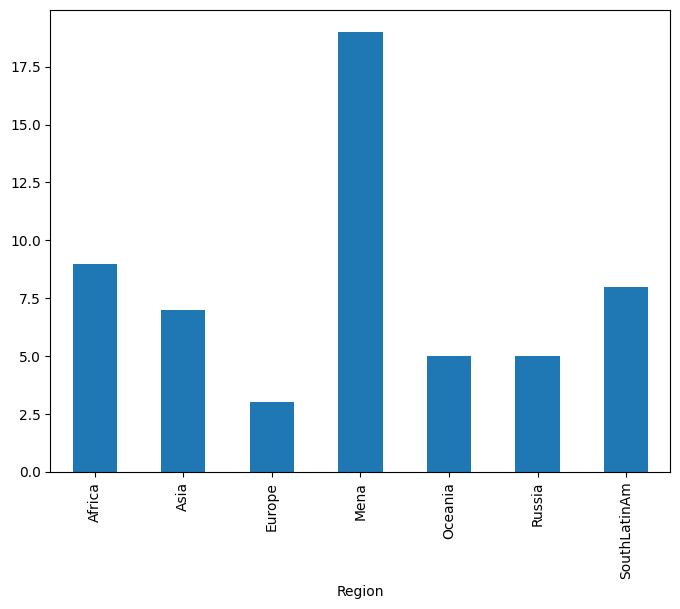

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Region').Description.count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Description).toarray()
labels = df.category_id
features.shape

(56, 276)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Region, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Region))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Africa':
  . Most correlated unigrams:
. africa
. african
  . Most correlated bigrams:
. unit state
. middl east
# 'Asia':
  . Most correlated unigrams:
. asian
. asia
  . Most correlated bigrams:
. cours student
. unit state
# 'Europe':
  . Most correlated unigrams:
. sourc
. ii
  . Most correlated bigrams:
. world war
. war ii
# 'Mena':
  . Most correlated unigrams:
. middl
. arab
  . Most correlated bigrams:
. east north
. middl east
# 'Oceania':
  . Most correlated unigrams:
. affair
. relationship
  . Most correlated bigrams:
. world war
. climat chang
# 'Russia':
  . Most correlated unigrams:
. elect
. russia
  . Most correlated bigrams:
. cours examin
. climat chang
# 'SouthLatinAm':
  . Most correlated unigrams:
. america
. latin
  . Most correlated bigrams:
. latin america
. latin american


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Region'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

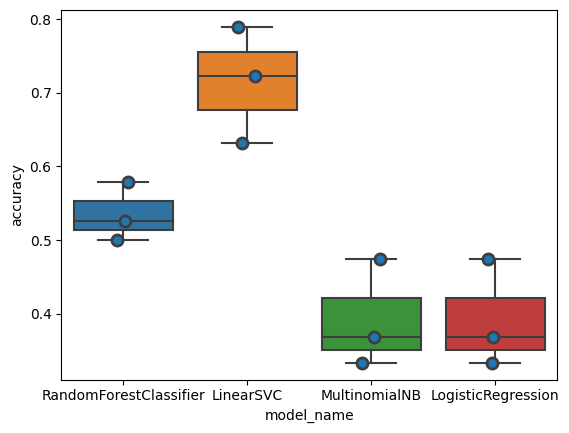

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [8]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.714425
LogisticRegression        0.391813
MultinomialNB             0.391813
RandomForestClassifier    0.535088
Name: accuracy, dtype: float64

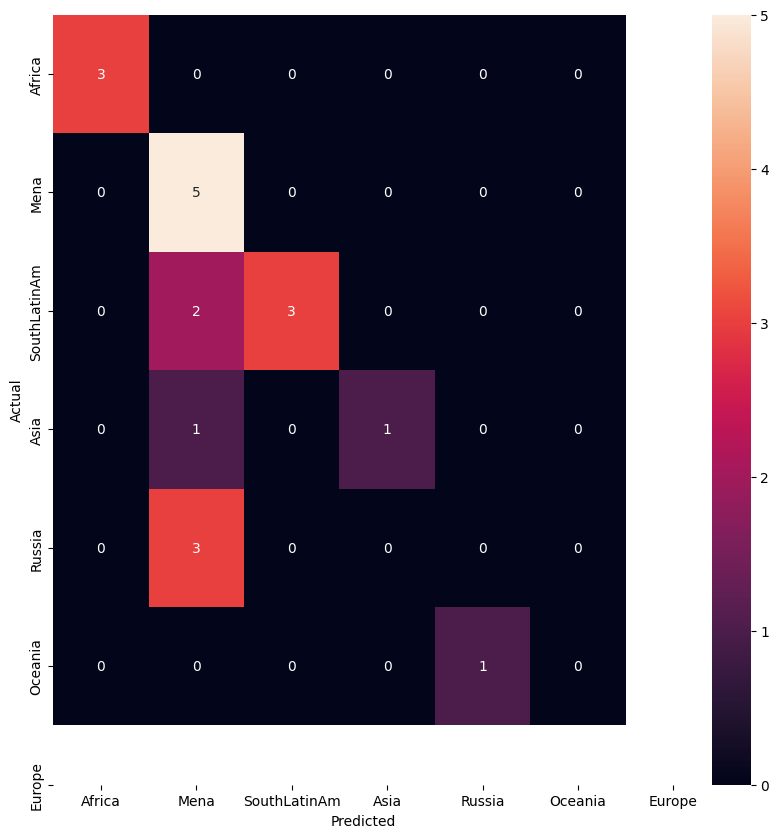

In [9]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Region.values, yticklabels=category_id_df.Region.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
model.fit(features, labels)
N = 2
for Region, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Region))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Africa':
  . Top unigrams:
       . africa
       . african
  . Top bigrams:
       . cours analyz
       . case studi
# 'Asia':
  . Top unigrams:
       . asia
       . unit
  . Top bigrams:
       . unit state
       . cours student
# 'Europe':
  . Top unigrams:
       . ii
       . sourc
  . Top bigrams:
       . war ii
       . world war
# 'Mena':
  . Top unigrams:
       . arab
       . middl
  . Top bigrams:
       . middl east
       . east north
# 'Oceania':
  . Top unigrams:
       . relationship
       . strateg
  . Top bigrams:
       . world war
       . climat chang
# 'Russia':
  . Top unigrams:
       . russia
       . elect
  . Top bigrams:
       . climat chang
       . case studi
# 'SouthLatinAm':
  . Top unigrams:
       . latin
       . america
  . Top bigrams:
       . latin american
       . latin america


In [14]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=['Africa', 'Mena', 'SouthLatinAm', 'Asia', 'Russia', 'Europe']))

              precision    recall  f1-score   support

      Africa       1.00      1.00      1.00         3
        Mena       0.45      1.00      0.62         5
SouthLatinAm       1.00      0.60      0.75         5
        Asia       1.00      0.50      0.67         2
      Russia       0.00      0.00      0.00         3
      Europe       0.00      0.00      0.00         1

    accuracy                           0.63        19
   macro avg       0.58      0.52      0.51        19
weighted avg       0.65      0.63      0.59        19



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.